In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import os
from pprint import pprint

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

BATCH_SIZE = 2
IMAGE_SIZE = (256, 384)
BBOX_FORMAT = "xywh"

class_map = {
    1: "box",
    2: "green_light",
    3: "left_arrow",
    4: "no_light",
    5: "person",
    6: "red_light",
    7: "right_arrow",
    8: "tree",
    9: "unknown_arrow",
}

2024-05-03 18:57:39.089436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 18:57:39.089598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 18:57:39.163676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 18:57:39.312168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 18:57:40.557629: W tensorflow/compiler/tf2

In [4]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="mediapipe/exported_model/model.tflite")
# interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

# interpreter.resize_tensor_input(input_details[0]["index"], (1, *IMAGE_SIZE, 3))

interpreter.allocate_tensors()

Input details: [{'name': 'serving_default_inputs:0', 'index': 0, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([  1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 426, 'shape': array([    1, 12276,     4], dtype=int32), 'shape_signature': array([    1, 12276,     4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:1', 'index': 424, 'shape': array([    1, 12276,    10], dtype=int32), 'shape_signature': array([    1, 12276,    10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'qua

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


tf.Tensor(
[[[0.6862745  0.7058824  0.654902  ]
  [0.6862745  0.7058824  0.6519608 ]
  [0.6862745  0.7058824  0.64705884]
  ...
  [0.03284314 0.04068628 0.03676471]
  [0.0377451  0.04068628 0.03921569]
  [0.03921569 0.03921569 0.03921569]]

 [[0.69293815 0.70543814 0.63313425]
  [0.6858303  0.70366114 0.6350796 ]
  [0.6791667  0.7058824  0.6435049 ]
  ...
  [0.02928922 0.03713235 0.03321078]
  [0.03196998 0.04157476 0.03121937]
  [0.03521753 0.04587929 0.0316636 ]]

 [[0.6936275  0.7053922  0.6242647 ]
  [0.6820619  0.7009498  0.62051165]
  [0.676777   0.7075368  0.62824756]
  ...
  [0.02354473 0.03345589 0.02953432]
  [0.0239277  0.03835785 0.03121937]
  [0.02487745 0.04325981 0.03419118]]

 ...

 [[0.8862286  0.8993873  0.8845589 ]
  [0.8812807  0.8950368  0.8845283 ]
  [0.88396144 0.89388794 0.8905791 ]
  ...
  [0.88357854 0.93247557 0.91617656]
  [0.8900123  0.9202206  0.9116575 ]
  [0.9016698  0.9183058  0.9138481 ]]

 [[0.86793816 0.9089921  0.8787225 ]
  [0.8739278  0.9000001  0

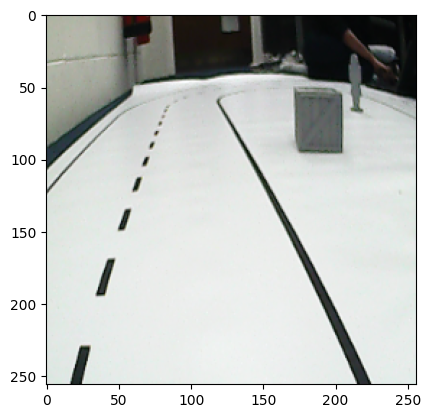

In [105]:
# Read and preprocess an image
_, input_height, input_width, _ = interpreter.get_input_details()[0]["shape"]
img = tf.io.read_file("label_data/test/downloads_images/1709570998863_90_35.png")
img = tf.io.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
# print(img)
original_image = img
resized_img = tf.image.resize(img, (input_height, input_width))
resized_img = resized_img[tf.newaxis, :]
resized_img = tf.cast(resized_img, dtype=tf.float32)
plt.imshow(resized_img[0])

# resized_img = (resized_img - 0.5) / 0.5
print(resized_img[0])

# print(resized_img.shape)
print(max(resized_img[0].numpy().flatten()))
print(min(resized_img[0].numpy().flatten()))

print(resized_img.shape)

In [106]:
# Print signatures
pprint(interpreter.get_signature_list())

signature_fn = interpreter.get_signature_runner("serving_default")

output = signature_fn(inputs=resized_img)

pprint(output)

#'outputs': ['detection_boxes', 'detection_scores']}}

print(output["detection_boxes"].shape)
print(output["detection_scores"].shape)

# Shape is (1, 12276, 4) for detection_boxes. Add a dimension to the end to make it (1, 12276, 1, 4)
output["detection_boxes"] = output["detection_boxes"][:, :, tf.newaxis, :]

print(output["detection_boxes"].shape)

{'serving_default': {'inputs': ['inputs'],
                     'outputs': ['detection_boxes', 'detection_scores']}}
{'detection_boxes': array([[[ 0.5667457 , -0.21096665, -1.5467784 , -1.8802471 ],
        [-0.0475191 ,  0.05186775, -2.129962  , -1.7360085 ],
        [-0.18870918,  0.20574829, -2.4253688 , -1.2779199 ],
        ...,
        [-0.38134342, -0.35824358, -0.92401254,  0.25307226],
        [-0.22104512, -0.19992188, -1.1661648 , -0.06196197],
        [-0.33386078, -0.09702086, -0.43247032, -0.57439846]]],
      dtype=float32),
 'detection_scores': array([[[0.00132673, 0.00542115, 0.00166283, ..., 0.00414128,
         0.00341194, 0.00249445],
        [0.00151299, 0.00264928, 0.00144521, ..., 0.00185226,
         0.00273689, 0.00230351],
        [0.00126078, 0.00119116, 0.00167455, ..., 0.00088799,
         0.00250108, 0.00245593],
        ...,
        [0.00036091, 0.00031638, 0.00037284, ..., 0.00017154,
         0.0003499 , 0.00052371],
        [0.00062026, 0.00013764, 0.0

In [107]:
pprint(output["detection_boxes"])

print(np.max(output["detection_boxes"]))
print(np.min(output["detection_boxes"]))

array([[[[ 0.5667457 , -0.21096665, -1.5467784 , -1.8802471 ]],

        [[-0.0475191 ,  0.05186775, -2.129962  , -1.7360085 ]],

        [[-0.18870918,  0.20574829, -2.4253688 , -1.2779199 ]],

        ...,

        [[-0.38134342, -0.35824358, -0.92401254,  0.25307226]],

        [[-0.22104512, -0.19992188, -1.1661648 , -0.06196197]],

        [[-0.33386078, -0.09702086, -0.43247032, -0.57439846]]]],
      dtype=float32)
1.673437
-2.9366567


In [108]:
boxes = tf.zeros_like(output["detection_boxes"])

x_center = (
    output["detection_boxes"][:, :, :, 0] + output["detection_boxes"][:, :, :, 2]
) / 2

In [109]:
# Load anchors from metadata
import json

with open("mediapipe/exported_model/metadata.json") as f:
    metadata = json.load(f)
    anchors = metadata["subgraph_metadata"][0]["custom_metadata"][0]["data"][
        "ssd_anchors_options"
    ]["fixed_anchors_schema"]["anchors"]
    # Convert list of dictionaries to array of arrays
    anchors = np.array(
        [
            [anchor["x_center"], anchor["y_center"], anchor["width"], anchor["height"]]
            for anchor in anchors
        ]
    )
    metadata = None

print(anchors)

[[0.015625 0.015625 0.066291 0.132583]
 [0.015625 0.015625 0.09375  0.09375 ]
 [0.015625 0.015625 0.132583 0.066291]
 ...
 [0.75     0.75     1.683693 3.367386]
 [0.75     0.75     2.381102 2.381102]
 [0.75     0.75     3.367386 1.683693]]


In [110]:
print(output["detection_boxes"].shape)

(1, 12276, 1, 4)


In [111]:
print(output["detection_boxes"][:, :, :, 0].shape)

(1, 12276, 1)


In [112]:
print(anchors.shape)

(12276, 4)


In [113]:
# Add another dim
print(anchors[tf.newaxis, :, 2].shape)

(1, 12276)


In [114]:
print(
    (
        output["detection_boxes"][:, :, :, 0] / x_scale * anchors[tf.newaxis, :, 2].T
    ).shape
)

(1, 12276, 1)


In [115]:
boxes = np.zeros_like(output["detection_boxes"])

scores = output["detection_scores"]

x_scale = 1
y_scale = 1
w_scale = 1
h_scale = 1

x_center = (
    output["detection_boxes"][:, :, :, 0] / x_scale * anchors[tf.newaxis, :, 2].T
    + anchors[tf.newaxis, :, 0].T
)
y_center = (
    output["detection_boxes"][:, :, :, 1] / y_scale * anchors[tf.newaxis, :, 3].T
    + anchors[tf.newaxis, :, 1].T
)
print(y_center.shape)

width = output["detection_boxes"][:, :, :, 2] / w_scale * anchors[tf.newaxis, :, 2].T
height = output["detection_boxes"][:, :, :, 3] / h_scale * anchors[tf.newaxis, :, 3].T

boxes[:, :, :, 0] = y_center - height / 2
boxes[:, :, :, 1] = x_center - width / 2
boxes[:, :, :, 2] = y_center + height / 2
boxes[:, :, :, 3] = x_center + width / 2

pprint(boxes)

(1, 12276, 1)
array([[[[ 0.11229881,  0.10446388, -0.13699   ,  0.00192639]],

        [[ 0.101863  ,  0.11101205, -0.0608878 , -0.08867189]],

        [[ 0.07162155,  0.15138671, -0.01309303, -0.17017597]],

        ...,

        [[-0.88244045,  0.88581145, -0.03024844, -0.66994196]],

        [[ 0.3477345 ,  1.6120477 ,  0.20019673, -1.1647096 ]],

        [[ 1.070202  ,  0.35390913,  0.10309133, -1.1023854 ]]]],
      dtype=float32)


In [118]:
nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections = (
    tf.image.combined_non_max_suppression(
        boxes,
        scores,
        max_output_size_per_class=5,
        max_total_size=5,
        iou_threshold=0.3,
        score_threshold=0.5,
    )
)

detections = {
    "detection_boxes": nmsed_boxes,
    "detection_scores": nmsed_scores,
    "detection_classes": nmsed_classes,
    "num_detections": valid_detections,
}

# pprint(detections)

pprint(detections)

{'detection_boxes': <tf.Tensor: shape=(1, 5, 4), dtype=float32, numpy=
array([[[0.29572576, 0.70264417, 0.2976856 , 0.7388411 ],
        [0.2651727 , 0.73485553, 0.26638222, 0.77187085],
        [0.25731245, 0.73238826, 0.33695793, 0.7223929 ],
        [0.31505328, 0.7226988 , 0.27478603, 0.7230809 ],
        [0.22815868, 0.74872977, 0.30653208, 0.73772424]]], dtype=float32)>,
 'detection_classes': <tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[1., 1., 1., 1., 1.]], dtype=float32)>,
 'detection_scores': <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.9228639 , 0.90407807, 0.9027526 , 0.8863732 , 0.8682995 ]],
      dtype=float32)>,
 'num_detections': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>}


320 240
[0.29572576 0.70264417 0.2976856  0.7388411 ]
224.84613418579102 70.97418308258057 11.583023071289062 0.47035932540893555
320 240
[0.2651727  0.73485553 0.26638222 0.77187085]
235.15377044677734 63.64144563674927 11.844902038574219 0.2902865409851074
320 240
[0.25731245 0.73238826 0.33695793 0.7223929 ]
234.36424255371094 61.75498723983765 -3.1985092163085938 19.11491632461548
320 240
[0.31505328 0.7226988  0.27478603 0.7230809 ]
231.26361846923828 75.61278820037842 0.12226104736328125 -9.66414213180542
320 240
[0.22815868 0.74872977 0.30653208 0.73772424]
239.59352493286133 54.75808382034302 -3.5217666625976562 18.809616565704346


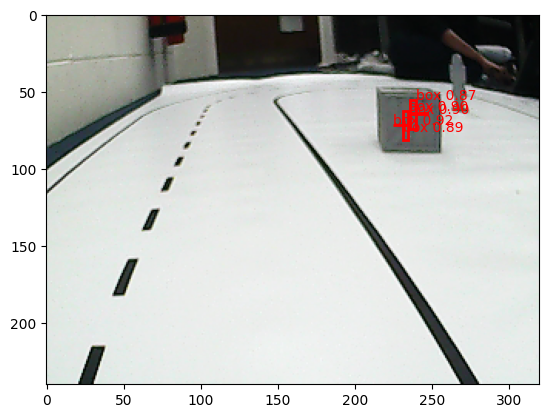

In [120]:
import matplotlib.pyplot as plt


# Draw the bounding boxes on the image
def visualise(img, detections):
    plt.imshow(img)

    for i in range(detections["num_detections"][0]):
        bbox = detections["detection_boxes"][0][i].numpy()
        score = detections["detection_scores"][0][i].numpy()
        class_id = detections["detection_classes"][0][i].numpy()

        class_name = class_map[class_id]

        img_width, img_height = img.shape[1], img.shape[0]
        print(img_width, img_height)

        print(bbox)
        y1, x1, y2, x2 = bbox
        origin_x, origin_y = x1 * img_width, y1 * img_height
        width, height = (x2 - x1) * img_width, (y2 - y1) * img_height

        print(origin_x, origin_y, width, height)

        rect = plt.Rectangle(
            (origin_x, origin_y),
            width,
            height,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        plt.gca().add_patch(rect)

        plt.text(origin_x, origin_y, f"{class_name} {score:.2f}", color="red")


visualise(original_image, detections)